In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy.matlib
import theano.tensor as tt
import warnings

from sklearn import preprocessing
from theano import shared
from scipy.special import expit as logistic
from scipy.special import softmax
from scipy.stats import betabinom
from matplotlib.patches import Ellipse, transforms

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
az.style.use('arviz-darkgrid')

In [3]:
RANDOM_SEED = 42
np.random.seed(42)

In [4]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.9.2
ArviZ 0.9.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 15 Missing Data and Other Opportunities

### Code 15.1

In [5]:
pancake = np.array([[1,1],[1,0],[0,0]])

In [6]:
# simulate a pancake and return randomly ordered sides
pancakes = np.asarray([np.random.permutation(pancake[np.random.choice(range(3))]) for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]

In [9]:
# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up==1)
num_11 = np.sum((up==1) & (down==1))
num_11/num_11_10

0.6576433121019108

In this chapter, you’ll meet two commonplace applications of this assume-and-deduce strategy. The first is the incorporation of **measurement error** into our models. The second is the estimation of missing data through **Bayesian imputation**. 

## 15.1. Measurement error

### Code 15.2

In [18]:
df = pd.read_csv('Data/WaffleDivorce.csv', ';')
df['log_population'] = np.log(df['Population'])
df

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,log_population
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000,1.564441
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000,-0.342490
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000,1.845300
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000,1.071584
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000,3.617652
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000,1.615420
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000,1.272566
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000,-0.105361
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000,-0.510826
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000,2.933857


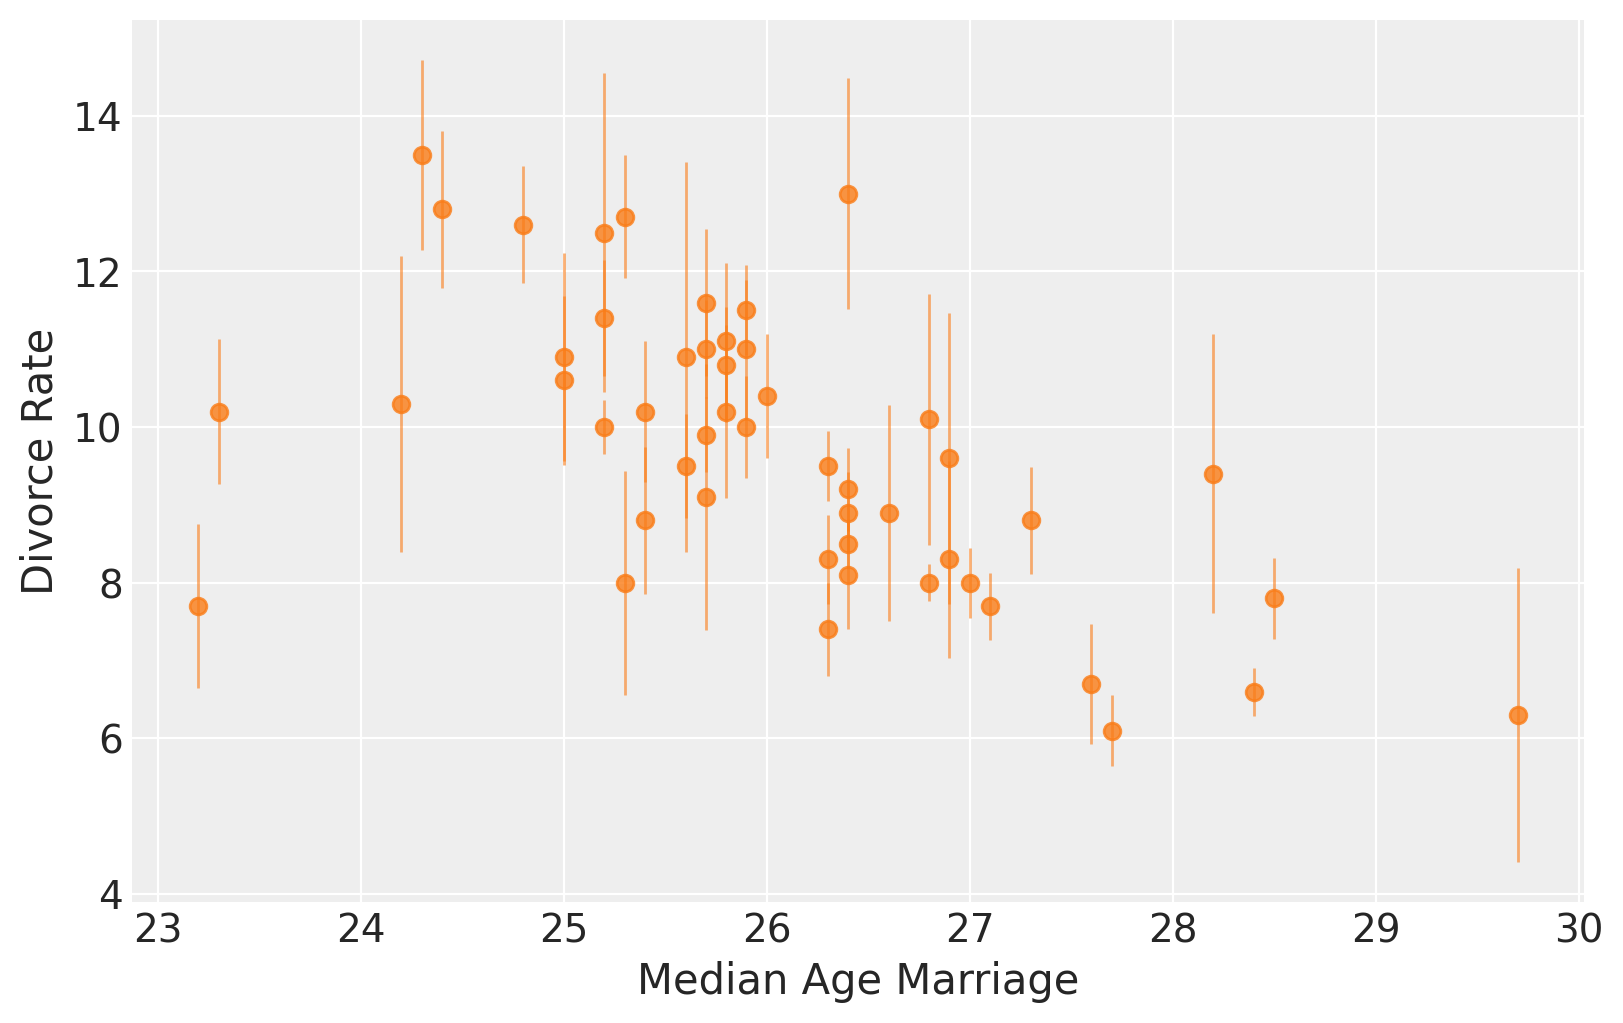

In [27]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['MedianAgeMarriage'], df['Divorce'],'C1o', alpha=0.8)
plt.errorbar(df['MedianAgeMarriage'], df['Divorce'], df['Divorce SE'].values, 
             ls='none', color='C1', linewidth=1,
             alpha=0.6)
plt.ylabel('Divorce Rate', fontsize=15)
plt.xlabel('Median Age Marriage', fontsize=15)
plt.show()

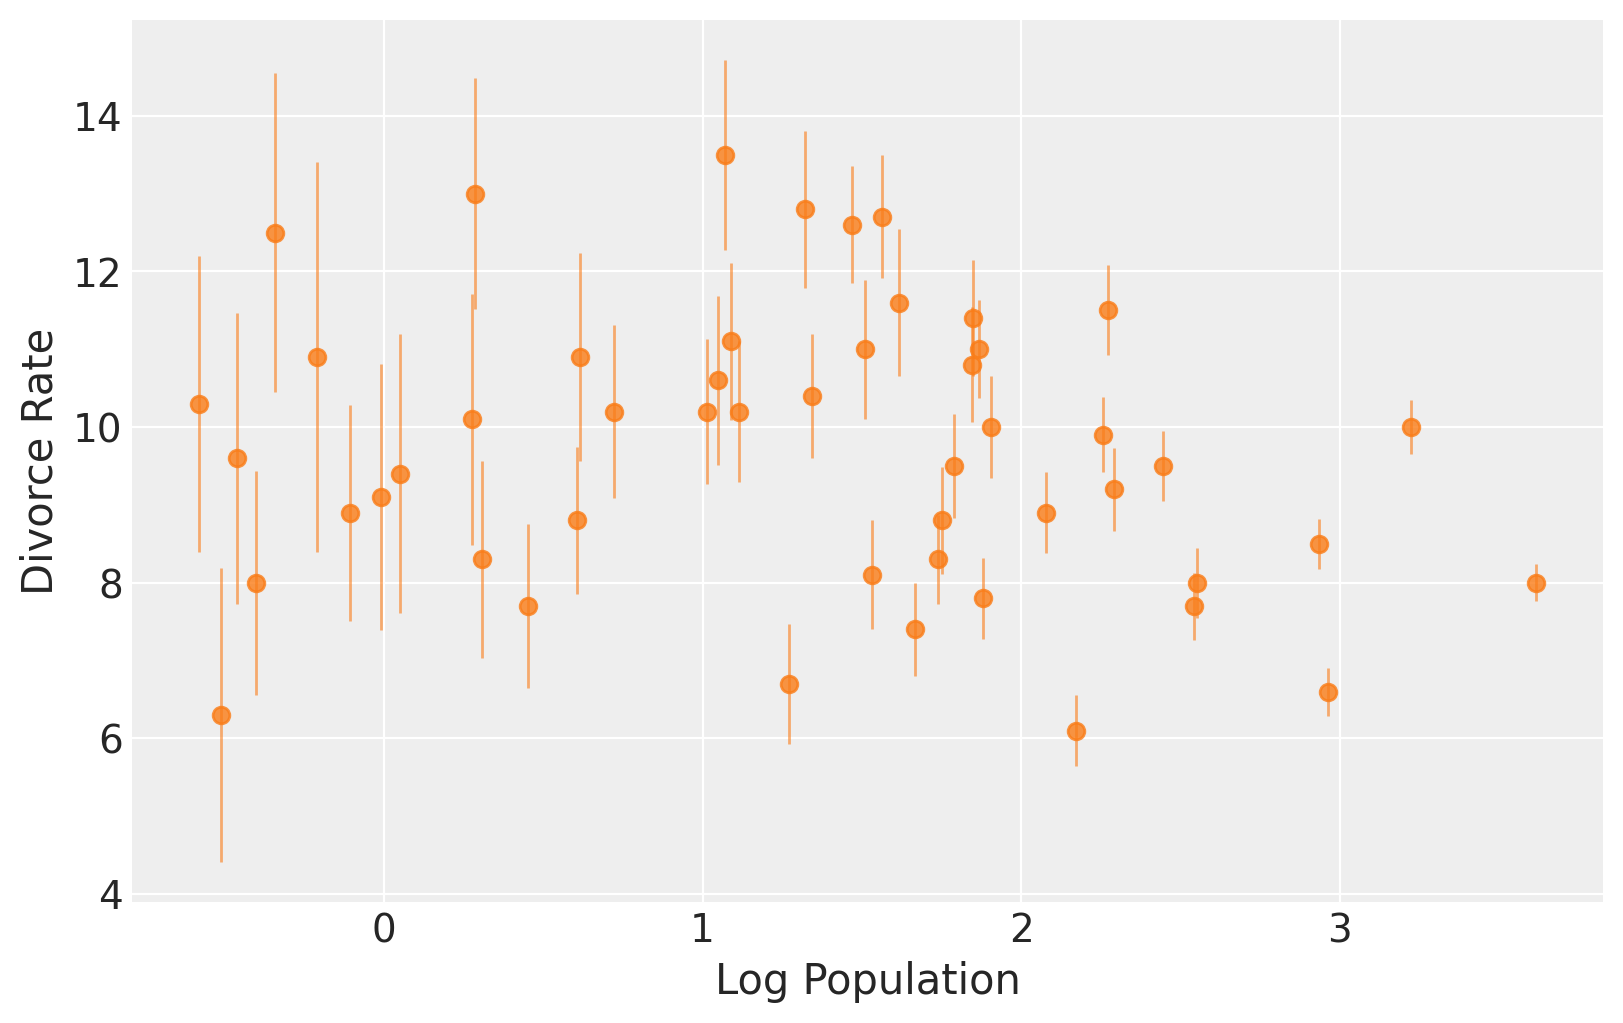

In [28]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['log_population'], df['Divorce'],'C1o', alpha=0.8)
plt.errorbar(df['log_population'], df['Divorce'], df['Divorce SE'].values, 
             ls='none', color='C1', linewidth=1,
             alpha=0.6)
plt.ylabel('Divorce Rate', fontsize=15)
plt.xlabel('Log Population', fontsize=15)
plt.show()

### 15.1.1. Error on the outcome

### Code 15.3

In [37]:
# standardize variables 
D_obs = preprocessing.scale(df['Divorce'])
D_sd = df['Divorce SE']/df['Divorce'].std()
M = preprocessing.scale(df['Marriage'])
A = preprocessing.scale(df['MedianAgeMarriage'])
N = len(df)

array([-0.61244489, -0.693671  , -0.20631433, -1.42470601,  0.6059468 ,
       -0.28754044,  1.2557557 ,  0.44349457,  2.96150405,  0.28104235,
       -0.12508821,  0.68717291, -2.31819324,  0.76839902, -0.28754044,
       -0.53121877, -0.85612322, -1.01857545, -0.12508821,  0.28104235,
        1.01207736,  1.98679071,  0.28104235,  0.19981624, -0.20631433,
       -0.36876655, -0.28754044, -0.53121877,  0.6059468 ,  1.33698181,
       -0.20631433,  1.90556459, -0.28754044, -0.61244489,  0.19981624,
       -1.3434799 , -0.0438621 ,  0.84962513,  1.74311237,  0.28104235,
       -0.36876655, -0.693671  , -0.693671  , -2.23696713,  0.68717291,
        0.28104235, -0.12508821, -0.85612322,  0.19981624, -1.50593212])

In [42]:
# define model: divorce rate ~ age at marriage A + marriage rate
with pm.Model() as m15_1:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=0.2)
    bA = pm.Normal('bA', mu=0.0, sd=0.5)
    bM = pm.Normal('bM', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', 1.0)
    
    # linear model
    mu = pm.Deterministic('mu', a + bA*A + bM*M)
    
    # likelihood for ture 
    D_true = pm.Normal('D_true', mu=mu, sd=sigma, shape=N)
    
    # likelihood for obs 
    D_est = pm.Normal('D_est', mu=D_true, sd=D_sd, observed=D_obs)
    
    trace_m15_1 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_1 = az.from_pymc3(trace_m15_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [43]:
# show model summary
varnames = ['~mu']
az.summary(idata_m15_1, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.05,0.10,-0.21,0.10
bA,-0.61,0.16,-0.86,-0.36
bM,0.05,0.16,-0.22,0.30
D_true[0],1.19,0.37,0.59,1.76
D_true[1],0.69,0.55,-0.11,1.62
D_true[2],0.45,0.34,-0.10,0.97
D_true[3],1.43,0.47,0.65,2.13
D_true[4],-0.91,0.13,-1.11,-0.71
D_true[5],0.68,0.39,0.06,1.30
D_true[6],-1.39,0.36,-1.94,-0.80


Ignoring measurement error tends to exaggerate associations between outcomes and predictors. But it might also mask an association. It all depends upon which cases have how much error.

### 15.1.2. Error on both outcome and predictor

### Code 15.5

In [44]:
# standardize variables 
D_obs = preprocessing.scale(df['Divorce'])
D_sd = df['Divorce SE']/df['Divorce'].std()
M_obs = preprocessing.scale(df['Marriage'])
M_sd = df['Marriage SE']/df['Marriage'].std()
A = preprocessing.scale(df['MedianAgeMarriage'])
N = len(df)

In [51]:
# define model: divorce rate ~ age at marriage A + marriage rate
with pm.Model() as m15_2:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=0.2)
    bA = pm.Normal('bA', mu=0.0, sd=0.5)
    bM = pm.Normal('bM', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', 1.0)
    
    # likelihood for M 
    M_est = pm.Normal('M_est', mu=0.0, sd=1.0, shape=N)
    
    # linear model
    mu = pm.Deterministic('mu', a + bA*A + bM*M_est)
    # likelihood for D
    D_est = pm.Normal('D_est', mu=mu, sd=sigma, shape=N)
    
    # likelihood for obs 
    D = pm.Normal('D', mu=D_est, sd=D_sd, observed=D_obs)
    M = pm.Normal('M', mu=M_est, sd=M_sd, observed=M_obs)
    
    trace_m15_2 = pm.sample(1000, tune=4000, target_accept=.95, random_seed=RANDOM_SEED)
    idata_m15_2 = az.from_pymc3(trace_m15_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_est, M_est, sigma, bM, bA, a]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 16 seconds.


In [52]:
# show model summary
varnames = ['~mu']
az.summary(idata_m15_2, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.04,0.10,-0.19,0.11
bA,-0.55,0.16,-0.79,-0.27
bM,0.19,0.21,-0.16,0.51
M_est[0],0.07,0.31,-0.43,0.55
M_est[1],1.02,0.61,0.01,1.97
...,...,...,...,...
D_est[46],0.15,0.30,-0.32,0.63
D_est[47],0.59,0.47,-0.13,1.32
D_est[48],-0.65,0.28,-1.13,-0.22
D_est[49],0.87,0.54,0.05,1.76


### Code 15.6

In [60]:
post = pm.sample_posterior_predictive(
        trace = trace_m15_2,
        samples = 1000,
        model = m15_2,
        random_seed=RANDOM_SEED)

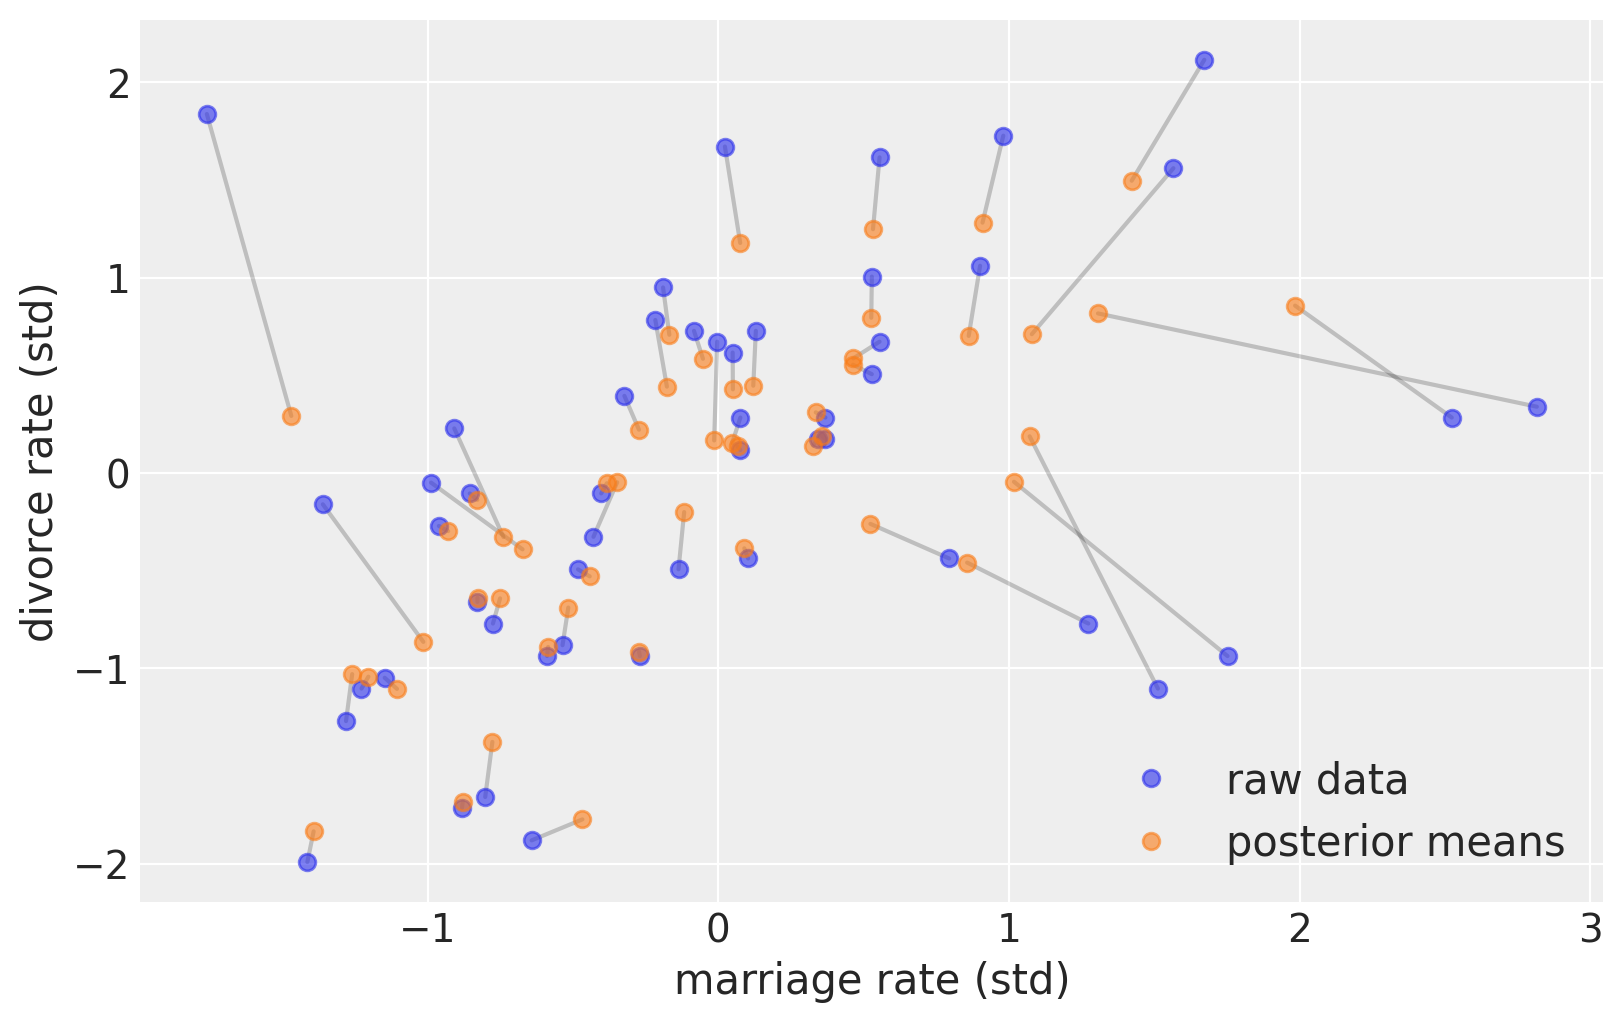

In [77]:
post_M = post['M'].mean(0)
post_D = post['D'].mean(0)
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot([M_obs, post_M], [D_obs, post_D], "k-", alpha=0.2)
plt.plot(M_obs, D_obs,'C0o', alpha=0.6, label='raw data')
plt.plot(post_M, post_D,'C1o', alpha=0.6, label='posterior means')
plt.legend(fontsize=15)
plt.ylabel('divorce rate (std)', fontsize=15)
plt.xlabel('marriage rate (std)', fontsize=15)
plt.show()

The big take home point for this section is that when you have a distribution of values, don’t reduce it down to a single value to use in a regression. Instead, use the entire distribu- tion. Anytime we use an average value, discarding the uncertainty around that average, we risk overconfidence and spurious inference. This doesn’t only apply to measurement error, but also to cases in which data are averaged before analysis.

### 15.1.3. Measurement terrors

### Code 15.7

In [82]:
N = 500
A = np.random.normal(size=N)
M = np.random.normal(loc=-A, size=N)
D = np.random.normal(loc=A, size=N)
A_obs = np.random.normal(loc=A, size=N)

## 15.2. Missing data

The most common treatment of missing values is just to drop all cases with any missing values. This is known as **complete case analysis**. 

We can think causally about missingness, and we can use the model to **impute** missing values. A generative model tells you whether the process that produced the missing values will also prevent the identification of causal effects. 

### 15.2.1. DAG ate my homework

### Code 15.8

In [40]:
N = 100
S = np.random.normal(size=N)
H = np.random.binomial(n=10, p=logistic(S), size=N)
H

array([ 3,  3,  8,  2,  6,  8,  1,  2,  8,  6,  2,  6,  8,  7,  2,  8,  8,
        7,  6,  2,  3,  7,  7,  8,  8,  1,  7,  5,  4,  8, 10,  8,  7,  2,
        6,  7,  5,  9,  9,  3,  8,  5,  6,  4,  3,  2,  6,  5,  4, 10,  3,
        4,  3,  6,  8,  7,  5,  6,  1,  1,  7,  7,  6,  2,  5,  5,  8,  5,
        3,  2,  0,  8,  2,  4,  5,  4,  8,  7,  6,  0,  7,  5,  5,  6,  2,
        8,  1,  4,  2, 10,  2,  9,  3,  1,  1,  8,  6,  4,  5,  8])

### Code 15.9

In [41]:
D = scipy.stats.bernoulli.rvs(p=0.5, size=N)
Hm = pd.Series(H)
Hm[D==1] = np.NaN
Hm

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
95    8.0
96    6.0
97    NaN
98    5.0
99    8.0
Length: 100, dtype: float64

### Code 15.10

In [65]:
D = np.array([1 if s < 0 else 0 for s in S])
Hm = pd.Series(H)
Hm[D==1] = np.NaN
Hm

0     NaN
1     NaN
2     8.0
3     NaN
4     6.0
     ... 
95    8.0
96    NaN
97    NaN
98    5.0
99    8.0
Length: 100, dtype: float64

### Code 15.11

In [80]:
N = 1000
X = np.random.normal(size=N)
S = np.random.normal(size=N)
H = np.random.binomial(n=10, p=logistic(2 + S - 2*X), size=N)
D = np.array([1 if x > 1 else 0 for x in X])
Hm = pd.Series(H)
Hm[D==1] = np.NaN

In [89]:
d = {'S': S, 'H': H}
df = pd.DataFrame(data=d)
df

,S,H
0,-0.364707,9
1,-0.372897,10
2,2.464702,10
3,-2.153746,10
4,-1.285965,6
...,...,...
995,1.071113,10
996,0.822640,7
997,-0.813996,10
998,-0.686813,8


### Code 15.12

In [95]:
# define model: H ~ S
with pm.Model() as m15_3:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=1.0)
    bS = pm.Normal('bS', mu=0.0, sd=0.5)
 
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a+bS*df.S.values))
     
    # likelihood
    H_est = pm.Binomial('H_est', n=10, p=p, observed=df.H.values)
    
    trace_m15_3 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_3 = az.from_pymc3(trace_m15_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [96]:
# show model summary
varnames = ['~p']
az.summary(idata_m15_3, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.22,0.03,1.18,1.26
bS,0.68,0.03,0.64,0.73


This is just a case of **omitted variable bias** (Chapter 10). Recall that in a generalized linear model, even if an unobserved variable like X doesn’t structurally confound or interact with the predictor of interest like S, that doesn’t mean that it won’t cause bias in estimation of the effect of S. The reason is that there are ceiling and floor effects on the outcome variable that induce interactions among all predictors.

### Code 15.13

In [97]:
d = {'S': S[D==0], 'H': H[D==0]}
df = pd.DataFrame(data=d)
df

,S,H
0,-0.364707,9
1,-0.372897,10
2,2.464702,10
3,-2.153746,10
4,-1.285965,6
...,...,...
832,1.071113,10
833,0.822640,7
834,-0.813996,10
835,-0.686813,8


In [98]:
# define model: H ~ S
with pm.Model() as m15_4:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=1.0)
    bS = pm.Normal('bS', mu=0.0, sd=0.5)
 
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a+bS*df.S.values))
     
    # likelihood
    H_est = pm.Binomial('H_est', n=10, p=p, observed=df.H.values)
    
    trace_m15_4 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_4 = az.from_pymc3(trace_m15_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [100]:
# show model summary
varnames = ['~p']
az.summary(idata_m15_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.84,0.04,1.78,1.89
bS,0.73,0.04,0.66,0.78


### Code 15.14

In [105]:
D = np.array([1 if abs(x) > 1 else 0 for x in X])
d = {'S': S[D==0], 'H': H[D==0]}
df = pd.DataFrame(data=d)

In [106]:
# define model: H ~ S
with pm.Model() as m15_4a:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=1.0)
    bS = pm.Normal('bS', mu=0.0, sd=0.5)
 
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a+bS*df.S.values))
     
    # likelihood
    H_est = pm.Binomial('H_est', n=10, p=p, observed=df.H.values)
    
    trace_m15_4a = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_4a = az.from_pymc3(trace_m15_4a)

# show model summary
varnames = ['~p']
az.summary(idata_m15_4a, varnames, kind='stats', round_to=2, hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
a,1.58,0.04,1.52,1.64
bS,0.83,0.04,0.77,0.89


### Code 15.15

In [108]:
N = 1000
S = np.random.normal(size=N)
H = np.random.binomial(n=10, p=logistic(S), size=N)
D = np.array([1 if h < 5 else 0 for h in H])
Hm = pd.Series(H)
Hm[D==1] = np.NaN

In [109]:
d = {'S': S[D==0], 'H': H[D==0]}
df = pd.DataFrame(data=d)

In [110]:
# define model: H ~ S
with pm.Model() as m15_4b:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=1.0)
    bS = pm.Normal('bS', mu=0.0, sd=0.5)
 
    # linear model
    p = pm.Deterministic('p', pm.math.invlogit(a+bS*df.S.values))
     
    # likelihood
    H_est = pm.Binomial('H_est', n=10, p=p, observed=df.H.values)
    
    trace_m15_4b = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_4b = az.from_pymc3(trace_m15_4b)

# show model summary
varnames = ['~p']
az.summary(idata_m15_4b, varnames, kind='stats', round_to=2, hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.45,0.04,0.38,0.50
bS,0.61,0.04,0.55,0.68


### 15.2.2. Imputing primates

Addressing missing data often involves the **imputation** of missing values. We impute both to avoid biased estimation and so that we can use all of the observed (not missing) data. The key idea with imputation is that any generative model necessarily contains information about variables that have not been observed. Some data go missing, but the model stays the same. In theory then imputing missing data is easy. In practice there can be challenges, as always.

The statistical trick with Bayesian imputation is to model the variable that has missing values. Each missing value is assigned a unique parameter. The observed values give us information about the distribution of the values. This distribution becomes a prior for the missing values. This prior will then be updated by full model. So there will be a posterior distribution for each missing value. Conceptually this is like the measurement error case—if we don’t know something, we condition it on what we know and let Bayes figure it out.

### Code 15.16

In [6]:
df = pd.read_csv('Data/milk.csv', ';')
df['neocortex.prop'] = df['neocortex.perc'] / 100
df['logmass'] = np.log(df['mass'])
df

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex.prop,logmass
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516,0.667829
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,NaN,0.737164
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,NaN,0.920283
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,NaN,0.482426
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,NaN,0.783902
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,0.6454,1.658228
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,0.6454,1.680828
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,0.6764,0.920283
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,NaN,-0.342490
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,0.6885,-0.385662


In [151]:
# standardize variables 
K = preprocessing.scale(df['kcal.per.g'])
B = preprocessing.scale(df['neocortex.prop'])
M = preprocessing.scale(df['logmass'])

In [143]:
# PyMC3 can handle missing value quite naturally.
B_mask = B.copy()
mask = np.isfinite(B_mask)
B_mask[~mask] = -999
B_mask = np.ma.masked_values(B_mask, value=-999)
B_mask

masked_array(data=[-2.144216983383405, --, --, --, --,
                   -0.5242954399602855, -0.5242954399602855,
                   0.011073087183813808, --, 0.22003951229489635,
                   -1.5069557365570392, -1.016489085883089,
                   -1.2530874349758054, --, --, 0.4134629801663151, --,
                   0.48945077111579965, --, 1.0058223505225317, --,
                   -0.007923860553557333, --, 0.6362453672682155,
                   0.8676627306143745, --, 0.4600918518853161,
                   1.506650972689592, 1.3667643575325832],
             mask=[False,  True,  True,  True,  True, False, False, False,
                    True, False, False, False, False,  True,  True, False,
                    True, False,  True, False,  True, False,  True, False,
                   False,  True, False, False, False],
       fill_value=-999.0)

In [144]:
# define model: K ~ B + M
with pm.Model() as m15_5:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=0.5)
    nu = pm.Normal('nu', mu=0.0, sd=0.5)
    bB = pm.Normal('bB', mu=0.0, sd=0.5)
    bM = pm.Normal('bM', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', 1.0)
    sigma_B = pm.Exponential('sigma_B', 1.0)
    
    # likelihood for B
    B_est = pm.Normal('B_est', mu=nu, sd=sigma_B, observed=B_mask) 
 
    # linear model
    mu = pm.Deterministic('mu', a + bB*B_est + bM*M)
     
    # likelihood for K
    K_est = pm.Normal('K_est', mu=mu, sd=sigma, observed=K)
    
    trace_m15_5 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_5 = az.from_pymc3(trace_m15_5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_est_missing, sigma_B, sigma, bM, bB, nu, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### Code 15.18

In [145]:
# show model summary
varnames = ['~mu']
az.summary(idata_m15_5, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.03,0.16,-0.23,0.29
nu,-0.04,0.21,-0.38,0.29
bB,0.49,0.24,0.14,0.90
bM,-0.55,0.20,-0.87,-0.22
B_est_missing[0],-0.56,0.93,-1.97,0.93
B_est_missing[1],-0.70,0.97,-2.15,0.91
B_est_missing[2],-0.73,0.99,-2.32,0.80
B_est_missing[3],-0.33,0.92,-1.66,1.25
B_est_missing[4],0.49,0.92,-0.92,1.97
B_est_missing[5],-0.18,0.94,-1.66,1.29


### Code 15.19

In [152]:
nan_index = np.isnan(B)
K = K[~nan_index]
B = B[~nan_index]
M = M[~nan_index]

In [153]:
# define model: K ~ B + M
with pm.Model() as m15_6:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=0.5)
    nu = pm.Normal('nu', mu=0.0, sd=0.5)
    bB = pm.Normal('bB', mu=0.0, sd=0.5)
    bM = pm.Normal('bM', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', 1.0)
    sigma_B = pm.Exponential('sigma_B', 1.0)
    
    # likelihood for B
    B_est = pm.Normal('B_est', mu=nu, sd=sigma_B, observed=B) 
 
    # linear model
    mu = pm.Deterministic('mu', a + bB*B_est + bM*M)
     
    # likelihood for K
    K_est = pm.Normal('K_est', mu=mu, sd=sigma, observed=K)
    
    trace_m15_6 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_6 = az.from_pymc3(trace_m15_6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_B, sigma, bM, bB, nu, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [154]:
# show model summary
varnames = ['~mu']
az.summary(idata_m15_6, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.10,0.20,-0.21,0.42
nu,0.00,0.23,-0.36,0.36
bB,0.60,0.27,0.17,1.01
bM,-0.64,0.25,-1.08,-0.30
sigma,0.89,0.18,0.61,1.16
sigma_B,1.07,0.19,0.78,1.37


### Code 15.20

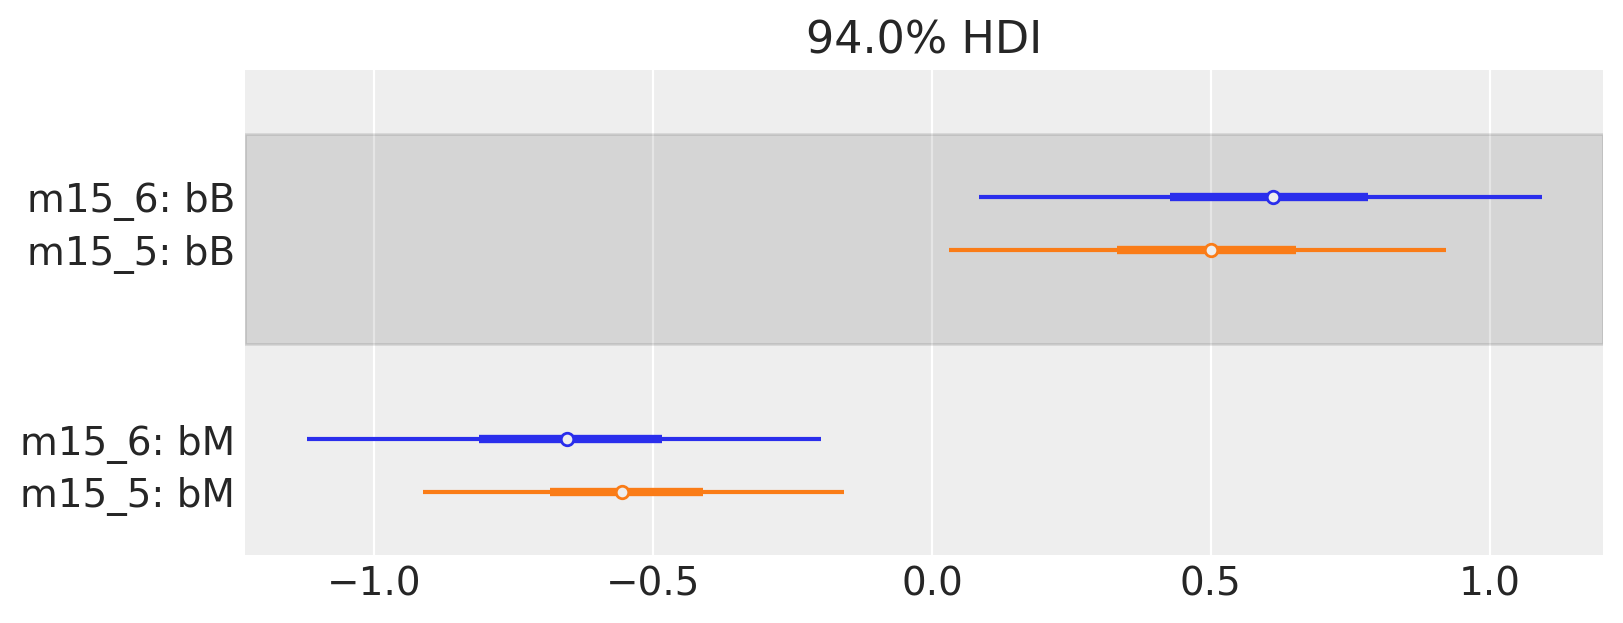

In [163]:
# plot results
az.plot_forest(
    [idata_m15_6, idata_m15_5],
    kind='forestplot',
    model_names=['m15_6', 'm15_5'],
    var_names=['bB','bM'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 3));

### Code 15.21

In [166]:
post = idata_m15_5.posterior = idata_m15_5.posterior.rename_vars(
        {'B_est_missing': 'B_impute'}) 

In [248]:
B_impute_mu = post['B_impute'].mean(dim={'draw','chain'}).to_pandas().values
B_impute_ci = az.hdi(post['B_impute'], hdi_prob=.94)['B_impute'].to_pandas().values

In [267]:
K = preprocessing.scale(df['kcal.per.g'])
B = preprocessing.scale(df['neocortex.prop'])
M = preprocessing.scale(df['logmass'])
nan_index = np.isnan(B)

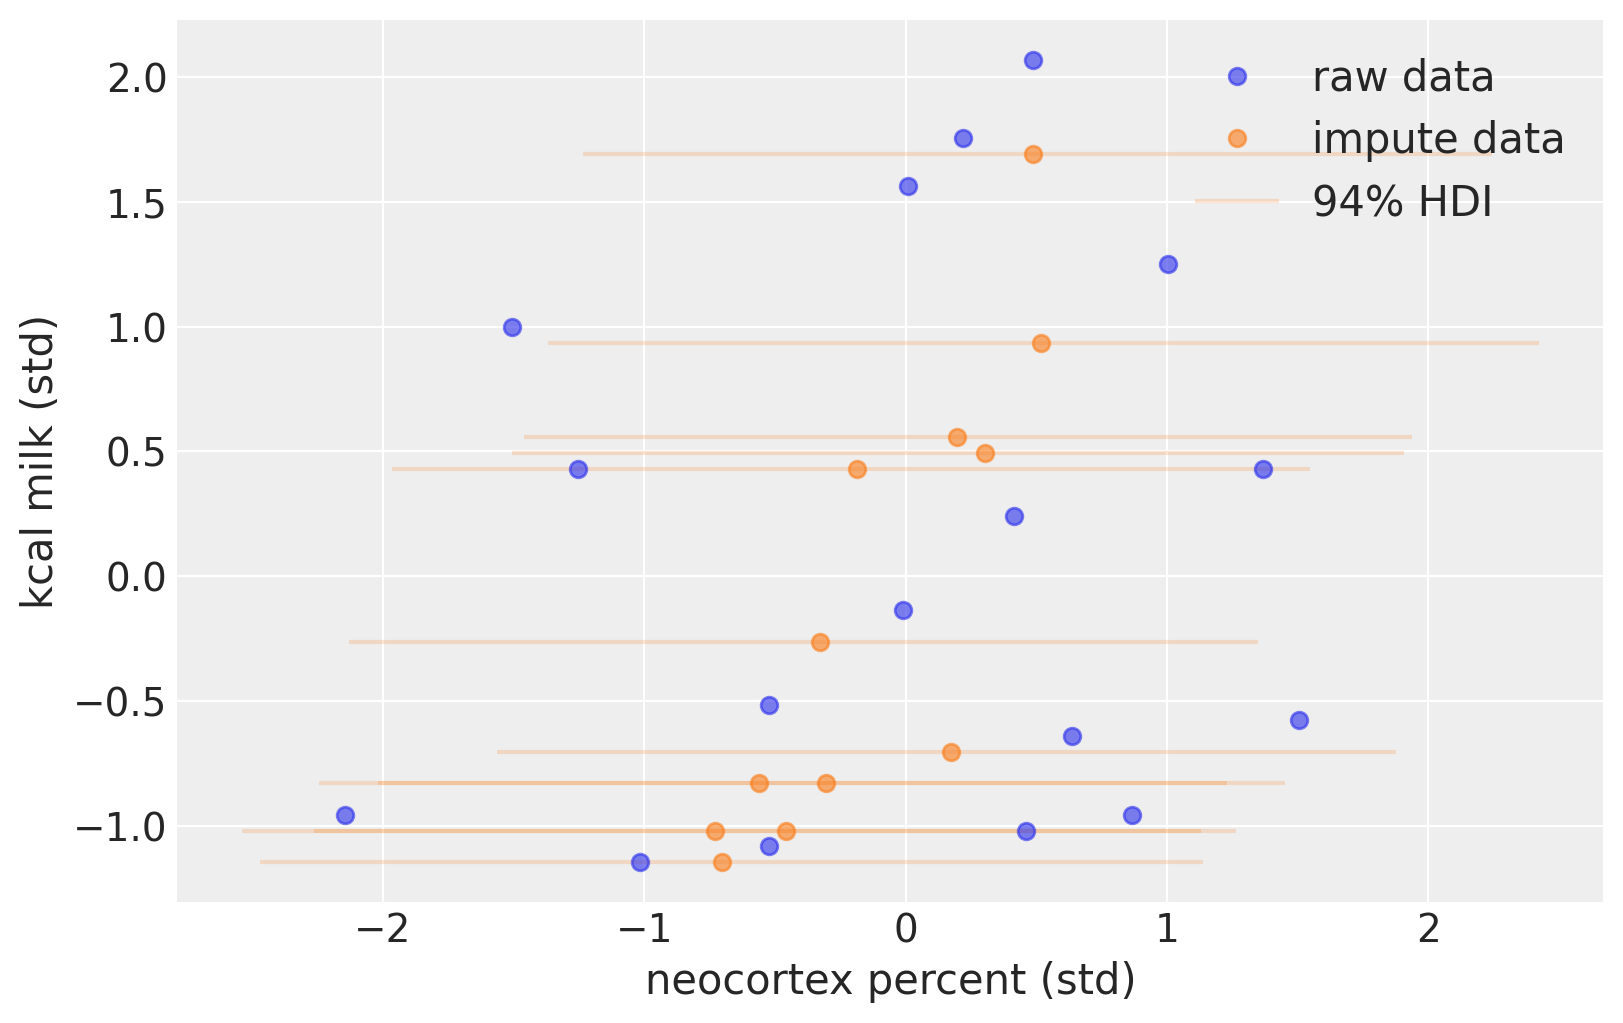

In [264]:
# B vs K
fig = plt.figure(figsize=(8, 5))
plt.plot(B[~nan_index], K[~nan_index],'C0o', alpha=0.6, label='raw data')
plt.plot(B_impute_mu, K[nan_index],'C1o', alpha=0.6, label='impute data')
plt.hlines(K[nan_index], B_impute_ci[:,0], B_impute_ci[:,1], 
           colors='C1', alpha=0.2, label='94% HDI')
plt.legend(fontsize=15)
plt.ylabel('kcal milk (std)', fontsize=15)
plt.xlabel('neocortex percent (std)', fontsize=15)
plt.show()

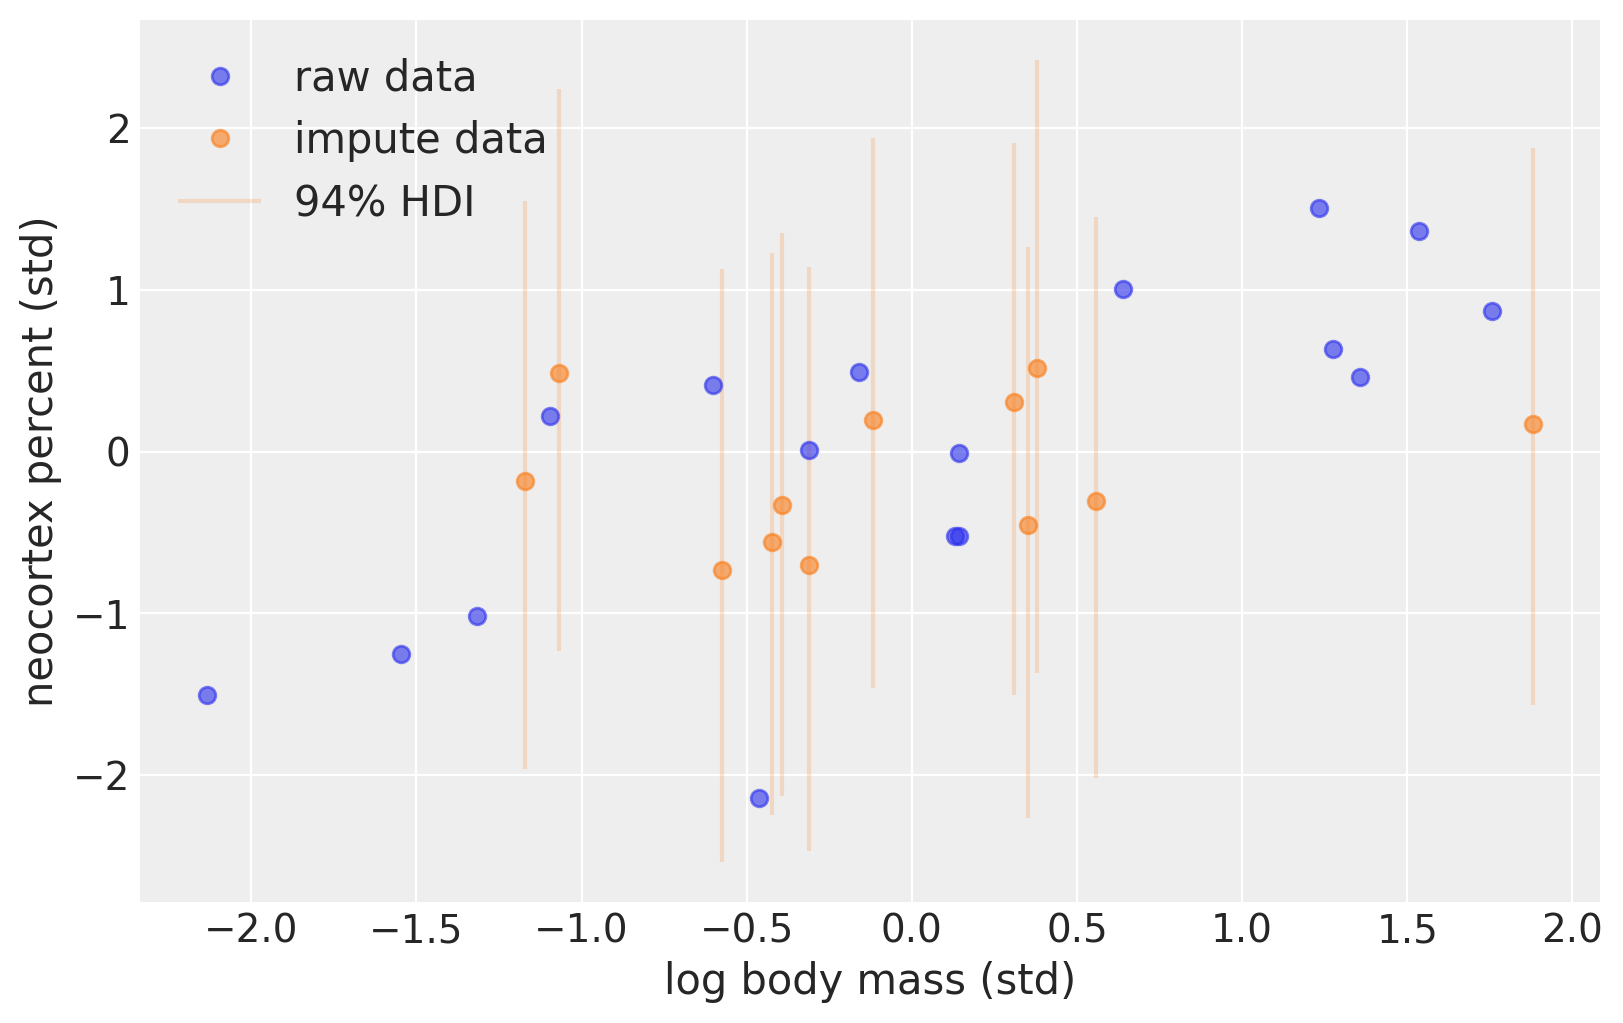

In [272]:
# M vs B
fig = plt.figure(figsize=(8, 5))
plt.plot(M[~nan_index], B[~nan_index],'C0o', alpha=0.6, label='raw data')
plt.plot(M[nan_index], B_impute_mu ,'C1o', alpha=0.6, label='impute data')
plt.vlines(M[nan_index], B_impute_ci[:,0], B_impute_ci[:,1], 
           colors='C1', alpha=0.2, label='94% HDI')
plt.legend(fontsize=15)
plt.xlabel('log body mass (std)', fontsize=15)
plt.ylabel('neocortex percent (std)', fontsize=15)
plt.show()

### Code 15.22

In [8]:
K = preprocessing.scale(df['kcal.per.g'])
B = preprocessing.scale(df['neocortex.prop'])
M = preprocessing.scale(df['logmass'])
N = len(df)
nan_index = np.isnan(B)

In [9]:
# PyMC3 can handle missing value quite naturally.
B_mask = B.copy()
mask = np.isfinite(B_mask)
B_mask[~mask] = -999
B_mask = np.ma.masked_values(B_mask, value=-999)

In [10]:
M_mask = M.copy()
mask = np.isfinite(M_mask)
M_mask[~mask] = -999
M_mask = np.ma.masked_values(M_mask, value=-999)

In [66]:
M_mask.data

array([-0.46390423, -0.4223481 , -0.31259493, -0.57502665, -0.39433575,
        0.12969657,  0.1432419 , -0.31259493, -1.06944477, -1.09532024,
       -2.13496272, -1.3166982 , -1.54709743, -1.17033744, -0.1184806 ,
       -0.6015009 ,  0.3089313 , -0.15958515,  0.37764102,  0.63997047,
        0.35062107,  0.1432419 ,  0.55756623,  1.27490952,  1.7579342 ,
        1.88213869,  1.35776516,  1.2334738 ,  1.53710024])

In [63]:
np.stack((B, M), axis = 1)

array([[-2.14421698, -0.46390423],
       [        nan, -0.4223481 ],
       [        nan, -0.31259493],
       [        nan, -0.57502665],
       [        nan, -0.39433575],
       [-0.52429544,  0.12969657],
       [-0.52429544,  0.1432419 ],
       [ 0.01107309, -0.31259493],
       [        nan, -1.06944477],
       [ 0.22003951, -1.09532024],
       [-1.50695574, -2.13496272],
       [-1.01648909, -1.3166982 ],
       [-1.25308743, -1.54709743],
       [        nan, -1.17033744],
       [        nan, -0.1184806 ],
       [ 0.41346298, -0.6015009 ],
       [        nan,  0.3089313 ],
       [ 0.48945077, -0.15958515],
       [        nan,  0.37764102],
       [ 1.00582235,  0.63997047],
       [        nan,  0.35062107],
       [-0.00792386,  0.1432419 ],
       [        nan,  0.55756623],
       [ 0.63624537,  1.27490952],
       [ 0.86766273,  1.7579342 ],
       [        nan,  1.88213869],
       [ 0.46009185,  1.35776516],
       [ 1.50665097,  1.2334738 ],
       [ 1.36676436,

In [83]:
MB_mask = np.ma.array(np.stack((M, B), axis = 1), mask = np.column_stack((~np.isfinite(M), ~np.isfinite(B))))

In [93]:
# define model: K ~ B + M
with pm.Model() as m15_7:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=0.5)
    muB = pm.Normal('muB', mu=0.0, sd=0.5)
    muM = pm.Normal('muM', mu=0.0, sd=0.5)
    bB = pm.Normal('bB', mu=0.0, sd=0.5)
    bM = pm.Normal('bM', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', 1.0)
    
    # MB_obs = pm.Data('MB_obs', np.stack((B, M), axis = 1))
    # MB_obs = pm.Data('MB_obs', np.stack((M_mask,B_mask),axis=1))
    # MB_obs = pm.Data('MB_obs', np.stack((B[~nan_index], M[~nan_index]),axis=1))
    # MB_obs = pm.Data('MB_obs', np.ma.array(np.stack((M, B), axis = 1), mask = np.column_stack((~np.isfinite(M), ~np.isfinite(B)))))
    
    # M and B correlation
    chol, _, _ = pm.LKJCholeskyCov('chol', n=2, eta=2,
                                   sd_dist=pm.Exponential.dist(1.0),
                                   compute_corr=True)    
    MB = pm.MvNormal('MB', mu=tt.stack((muM, muB)), chol=chol, shape=(N, 2))
    
    # linear model
    mu = pm.Deterministic('mu', a + bB*MB[:,1] + bM*M)
     
    # likelihood for K
    K_est = pm.Normal('K_est', mu=mu, sd=sigma, observed=K)
    
    trace_m15_7 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_7 = az.from_pymc3(trace_m15_7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [MB, chol, sigma, bM, bB, muM, muB, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 7.382111365389458e-15, but should be close to 0.8. Try to increase the number of tuning steps.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5024035076266469, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [94]:
# show model summary
varnames = ['~mu','~MB']
az.summary(idata_m15_7, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.02,0.22,-0.39,0.30
muB,0.03,0.38,-0.59,0.61
muM,0.12,0.44,-0.64,0.72
bB,-0.05,0.45,-0.81,0.69
bM,-0.29,0.16,-0.55,-0.02
sigma,0.88,0.23,0.47,1.23
chol[0],0.76,0.77,0.10,1.52
chol[1],0.24,0.59,-0.50,0.92
chol[2],1.04,0.73,0.14,1.78
chol_stds[0],0.76,0.77,0.10,1.52


## 15.3. Categorical errors and discrete absences

In almost every case, we don’t need to sample discrete parameters at all. Instead we can use a special technique, known to experts as a “weighted average,” to remove discrete parameters from the model. After sampling the other parameters, we can then use their samples to compute the posterior distribution of any discrete parameter. 

### 15.3.1. Discrete cats

### Code 15.29

In [95]:
N_houses = 100
alpha = 5
beta = (-3)
k = 0.5
r = 0.2
cat = scipy.stats.bernoulli.rvs(p=k, size=N_houses)
notes = np.random.poisson(lam=alpha + beta*cat, size=N_houses)
R_C = scipy.stats.bernoulli.rvs(p=r, size=N_houses)
cat_obs = cat.copy()
cat_obs[R_C==1] = -9

### Code 15.30


In [ ]:
# define model: N ~ C 
with pm.Model() as m15_7:

    # fixed priors
    a = pm.Normal('a', mu=0.0, sd=1.0)
    b = pm.Normal('b', mu=0.0, sd=0.5)
    
    ## cat known present/absent:
    
    
    
    # MB_obs = pm.Data('MB_obs', np.stack((B, M), axis = 1))
    # MB_obs = pm.Data('MB_obs', np.stack((M_mask,B_mask),axis=1))
    MB_obs = pm.Data('MB_obs', np.stack((B[~nan_index], M[~nan_index]),axis=1))
    
    # M and B correlation
    chol, _, _ = pm.LKJCholeskyCov('chol', n=2, eta=2,
                                   sd_dist=pm.Exponential.dist(1.0),
                                   compute_corr=True)    
    MB = pm.MvNormal('MB', mu=tt.stack((muM, muB)).T, chol=chol, shape=(N, 2), observed=MB_obs)
    
    # linear model
    mu = pm.Deterministic('mu', a + bB*MB[:,1] + bM*M[~nan_index])
     
    # likelihood for K
    K_est = pm.Normal('K_est', mu=mu, sd=sigma, observed=K[~nan_index])
    
    trace_m15_7 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m15_7 = az.from_pymc3(trace_m15_7)